In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grad[key]

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))

In [4]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
    
    def update(self, params, grads):
        if self.m is None:
            self.m , self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grad[key] - self.m[key]) 
            self.v[key] += (1 - self.beta2) * (grad[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

# 隠れ層のアクティベーション分布

In [5]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def tanh(x):
    return np.tanh(x)

def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1
    
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

# ヒストグラムの描画

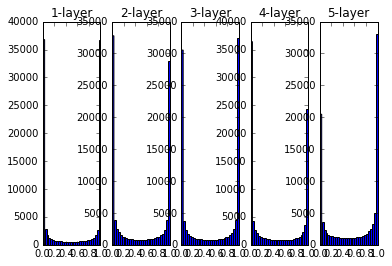

In [14]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

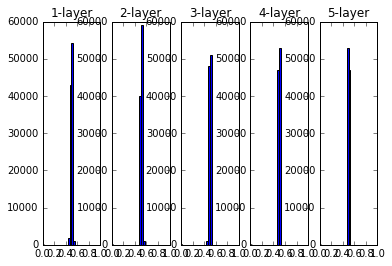

In [19]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01
    
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# Xavierの初期値

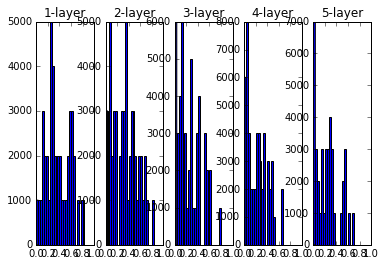

In [20]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    
    z = np.dot(x, w)
    a = tanh(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# Heの初期値

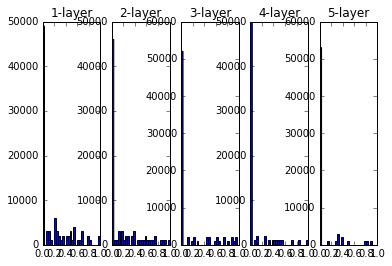

In [21]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = 2 * np.random.randn(node_num, node_num) / np.sqrt(node_num)
    
    z = np.dot(x, w)
    a = ReLU(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# 初期の重みの比較

In [32]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.optimizer import SGD

from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

In [50]:
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size,
                activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}
        
        self.__init_weight(weight_init_std)
        
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
        self.last_layer = SoftmaxWithLoss()
        
    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
        
        return self.last_layer.forward(y, t) + weight_decay
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t =np.argmax(t, axis=1)
            
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
        return grads

In [51]:
# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

In [52]:
# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

In [53]:
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
He:2.27152818591
Xavier:2.2955966211
std=0.01:2.30252390758
===========iteration:100===========
He:1.4325226978
Xavier:2.25077540084
std=0.01:2.30195911175
===========iteration:200===========
He:0.75907013839
Xavier:2.09740677444
std=0.01:2.30130269834
===========iteration:300===========
He:0.620669670762
Xavier:1.8577246503
std=0.01:2.30170796256
===========iteration:400===========
He:0.416608839416
Xavier:1.2295041291
std=0.01:2.30230901912
===========iteration:500===========
He:0.417539571429
Xavier:0.865294661967
std=0.01:2.30433093375
===========iteration:600===========
He:0.4022263455
Xavier:0.632845854633
std=0.01:2.29811740903
===========iteration:700===========
He:0.317618011918
Xavier:0.551524904923
std=0.01:2.30306199995
===========iteration:800===========
He:0.323655382472
Xavier:0.446401629098
std=0.01:2.29565007745
===========iteration:900===========
He:0.236915392715
Xavier:0.398562995809
std=0.01:2.29928738614
===========iteration:1000=

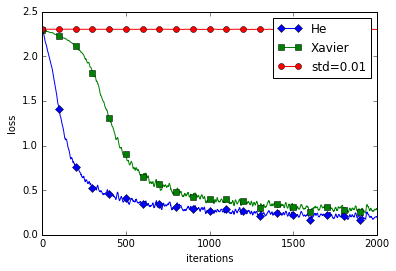

In [54]:
# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# Batch Normalization

In [55]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import SGD, Adam

In [77]:
class MultiLayerNetExtend:
    def __init__(self, input_size, hidden_size_list, output_size,
                activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                use_dropout = False, dropout_ration = 0.5, use_batchnorm = False):
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}
        
        self.__init_weight(weight_init_std)
        
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
        
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx - 1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx - 1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
            
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)
        
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
        
        self.last_layer = SoftmaxWithLoss()
        
    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
    
    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg) 
            else:
                x = layer.forward(x)
        
        return x
    
    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
        
        return self.last_layer.forward(y, t) + weight_decay
    
    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t =np.argmax(t, axis=1)
            
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx) ] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx) ] = numerical_gradient(loss_W, self.params['beta' + str(idx)])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t, train_flg=True)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx) ] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx) ] = self.layers['BatchNorm' + str(idx)].dbeta
            
        return grads

# BatchNormalization動作

In [78]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

In [79]:
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_eopch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
            
        if i % iter_per_eopch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
            
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

/home/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
/home/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


============== 1/16 ==============
epoch:0 | 0.117 - 0.119
epoch:1 | 0.097 - 0.106
epoch:2 | 0.097 - 0.152
epoch:3 | 0.097 - 0.199
epoch:4 | 0.097 - 0.232
epoch:5 | 0.097 - 0.258
epoch:6 | 0.097 - 0.274
epoch:7 | 0.097 - 0.306
epoch:8 | 0.097 - 0.322
epoch:9 | 0.097 - 0.351
epoch:10 | 0.097 - 0.364
epoch:11 | 0.097 - 0.39
epoch:12 | 0.097 - 0.403
epoch:13 | 0.097 - 0.416
epoch:14 | 0.097 - 0.448
epoch:15 | 0.097 - 0.457
epoch:16 | 0.097 - 0.477
epoch:17 | 0.097 - 0.502
epoch:18 | 0.097 - 0.512
epoch:19 | 0.097 - 0.514
============== 2/16 ==============
epoch:0 | 0.117 - 0.129
epoch:1 | 0.097 - 0.158
epoch:2 | 0.097 - 0.161
epoch:3 | 0.097 - 0.182
epoch:4 | 0.097 - 0.189
epoch:5 | 0.097 - 0.218
epoch:6 | 0.097 - 0.268
epoch:7 | 0.097 - 0.302
epoch:8 | 0.097 - 0.349
epoch:9 | 0.097 - 0.377
epoch:10 | 0.097 - 0.408
epoch:11 | 0.097 - 0.432
epoch:12 | 0.097 - 0.456
epoch:13 | 0.097 - 0.48
epoch:14 | 0.097 - 0.51
epoch:15 | 0.097 - 0.518
epoch:16 | 0.097 - 0.54
epoch:17 | 0.097 - 0.573
epoc

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


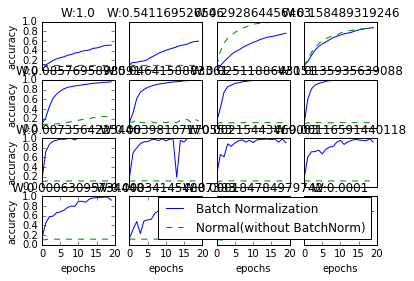

In [80]:
# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

============== 1/16 ==============
epoch:0 | 0.116 - 0.1142
epoch:1 | 0.122 - 0.1241
epoch:2 | 0.148 - 0.148
epoch:3 | 0.186 - 0.1859
epoch:4 | 0.277 - 0.2572
epoch:5 | 0.391 - 0.3382
epoch:6 | 0.453 - 0.3978
epoch:7 | 0.503 - 0.4506
epoch:8 | 0.553 - 0.5064
epoch:9 | 0.608 - 0.5444
epoch:10 | 0.636 - 0.5667
epoch:11 | 0.664 - 0.6062
epoch:12 | 0.697 - 0.6298
epoch:13 | 0.712 - 0.6427
epoch:14 | 0.742 - 0.6596
epoch:15 | 0.768 - 0.6946
epoch:16 | 0.795 - 0.7082
epoch:17 | 0.781 - 0.7175
epoch:18 | 0.803 - 0.7354
epoch:19 | 0.821 - 0.747
============== 2/16 ==============
epoch:0 | 0.121 - 0.118
epoch:1 | 0.188 - 0.1634
epoch:2 | 0.225 - 0.2047
epoch:3 | 0.317 - 0.2757
epoch:4 | 0.359 - 0.3261
epoch:5 | 0.45 - 0.3973
epoch:6 | 0.5 - 0.4513
epoch:7 | 0.57 - 0.5071
epoch:8 | 0.629 - 0.5525
epoch:9 | 0.697 - 0.6111
epoch:10 | 0.723 - 0.6399
epoch:11 | 0.749 - 0.669
epoch:12 | 0.762 - 0.6793
epoch:13 | 0.784 - 0.7018
epoch:14 | 0.805 - 0.7154
epoch:15 | 0.814 - 0.7348
epoch:16 | 0.83 - 0.74

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


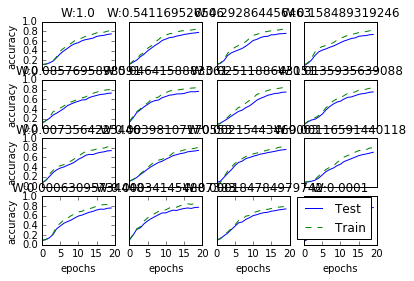

In [84]:
def __train(weight_init_std):
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10)
    optimizer = SGD(lr=0.01)
    
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    
    iter_per_eopch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)
            
        if i % iter_per_eopch == 0:
            train_acc = network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            test_acc = network.accuracy(x_test, t_test)
            test_acc_list.append(test_acc)
            
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(test_acc))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, test_acc_list
            
# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, test_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, test_acc_list, label='Test', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Train', markevery=2)
    else:
        plt.plot(x, test_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

============== 1/16 ==============
epoch:0 | 0.089 - 0.0927
epoch:1 | 0.15 - 0.1439
epoch:2 | 0.208 - 0.1852
epoch:3 | 0.253 - 0.2215
epoch:4 | 0.287 - 0.252
epoch:5 | 0.295 - 0.2672
epoch:6 | 0.31 - 0.2802
epoch:7 | 0.319 - 0.2923
epoch:8 | 0.361 - 0.3231
epoch:9 | 0.405 - 0.349
epoch:10 | 0.408 - 0.3619
epoch:11 | 0.44 - 0.3889
epoch:12 | 0.47 - 0.4188
epoch:13 | 0.511 - 0.4557
epoch:14 | 0.529 - 0.4732
epoch:15 | 0.57 - 0.5096
epoch:16 | 0.565 - 0.5068
epoch:17 | 0.597 - 0.5409
epoch:18 | 0.623 - 0.5608
epoch:19 | 0.627 - 0.567
============== 2/16 ==============
epoch:0 | 0.093 - 0.101
epoch:1 | 0.097 - 0.104
epoch:2 | 0.135 - 0.1248
epoch:3 | 0.222 - 0.1913
epoch:4 | 0.315 - 0.2706
epoch:5 | 0.399 - 0.3481
epoch:6 | 0.472 - 0.3962
epoch:7 | 0.515 - 0.4351
epoch:8 | 0.551 - 0.473
epoch:9 | 0.572 - 0.4906
epoch:10 | 0.585 - 0.5142
epoch:11 | 0.584 - 0.5156
epoch:12 | 0.605 - 0.5407
epoch:13 | 0.615 - 0.5555
epoch:14 | 0.647 - 0.5787
epoch:15 | 0.658 - 0.5862
epoch:16 | 0.661 - 0.5939

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


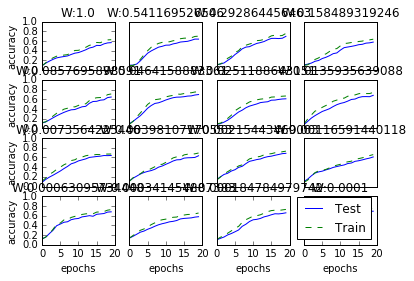

In [85]:
weight_decay_lambda = 0.1

def __train(weight_init_std):
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                 weight_decay_lambda=weight_decay_lambda)
    optimizer = SGD(lr=0.01)
    
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    
    iter_per_eopch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)
            
        if i % iter_per_eopch == 0:
            train_acc = network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            test_acc = network.accuracy(x_test, t_test)
            test_acc_list.append(test_acc)
            
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(test_acc))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, test_acc_list
            
# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, test_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, test_acc_list, label='Test', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Train', markevery=2)
    else:
        plt.plot(x, test_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

# Trainer

In [93]:
from common.optimizer import *

class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                epochs=20, mini_batch_size=100,
                optimizer='SGD', optimizer_param={'lr':0.01},
                evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch
        
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                               'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        
    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            
            if self.verbose:
                print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1
        
    def train(self):
        for i in range(self.max_iter):
            self.train_step()
        
        test_acc = self.network.accuracy(self.x_test, self.t_test)
        
        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

train loss:2.31368709678
=== epoch:1, train acc:0.11, test acc:0.0937 ===
train loss:2.30969335833
train loss:2.30395200444
train loss:2.28934210515
=== epoch:2, train acc:0.113333333333, test acc:0.0937 ===
train loss:2.29458376674
train loss:2.30867265533
train loss:2.29776676881
=== epoch:3, train acc:0.116666666667, test acc:0.0947 ===
train loss:2.28913432263
train loss:2.2853019349
train loss:2.31220372158
=== epoch:4, train acc:0.113333333333, test acc:0.0957 ===
train loss:2.29371570287
train loss:2.30430555568
train loss:2.29574938582
=== epoch:5, train acc:0.116666666667, test acc:0.0969 ===
train loss:2.31457034775
train loss:2.30664952801
train loss:2.30172368682
=== epoch:6, train acc:0.116666666667, test acc:0.0966 ===
train loss:2.29911549976
train loss:2.29709148109
train loss:2.31466404966
=== epoch:7, train acc:0.116666666667, test acc:0.0972 ===
train loss:2.3135427061
train loss:2.30438412383
train loss:2.28281955778
=== epoch:8, train acc:0.116666666667, test acc:0

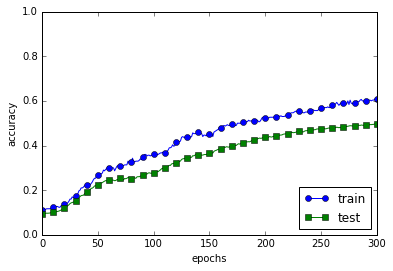

In [94]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()